<img src="//tiny.cc/devnetlogo" alt="Logo">
    
# Cisco Connect 2020 - Anomaly Detection Click-through Demo

<img src='./Image2.png' style="width: 500px;">

### Artifical Intelligence & Machine Learning in Cisco
https://www.cisco.com/c/en/us/solutions/artificial-intelligence.html

### Introduction

In this click-through demo, you will build a machine learning model and
apply it to detect failing servers on a network.

We start from two inputs (throughput and latency) to identify the normal vs anomaly. And we expand the method into multiple inputs scenario.

#### Import All Required Libraries
##### How to execute this code: Highlight this cell, then press "Shift+Return(Enter)"

In [1]:
# used for manipulating directory paths
import os

# vector computation and dataframe for python
import numpy as np
import pandas as pd

# Plotting library
import matplotlib.pyplot as plt 

# tells matplotlib to embed plots within the notebook
%matplotlib inline

This imports the modules and information we need to build anomaly detection model, no output expected

### 1. Data Visulization
- Latency: The time taken for a packet to be transferred across a network. You can measure this as one-way to its destination or as a round trip.
- Throughput: The quantity of data being sent and received within a unit of time

In [2]:
# import two dimensions data train set and convert from pandas dataframe to numpy array
train_two_dimension = pd.read_csv('./data/train_two_dimensions.csv')
train_two_dimension = np.array(train_two_dimension)

X_train_two_dimension = train_two_dimension[:,:-1]
y_train_two_dimension = train_two_dimension[:,-1]

### import test set two dimensions data and convert from pandas dataframe to numpy array
test_two_dimension = pd.read_csv('./data/test_two_dimensions.csv')
test_two_dimension = np.array(test_two_dimension)

X_test_two_dimension = test_two_dimension[:,:-1]
y_test_two_dimension = test_two_dimension[:,-1]

Those code above loads data. No output expected

In [3]:
# Visualize the data
def plotData(myX, newFig=False):
        
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.plot(myX[:,0],myX[:,1],'b+')
    ax.set_xlabel('Latency [ms]',fontsize=16)
    ax.set_ylabel('Throughput [mb/s]',fontsize=16)
    ax.grid(linestyle="-.")

The function 'plotData' above build function to plot data. No output expected

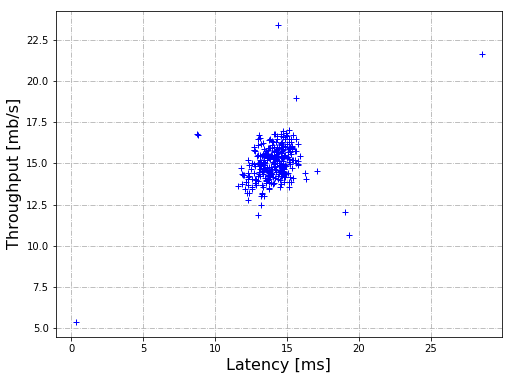

In [4]:
plotData(X_train_two_dimension)

### 2. Gaussian Distribution

To perform anomaly detection, first we fit a model to the data's distribution. Given a training set $\{x^{(1)}, \dots, x^{(m)} \}$ (where $x^{(i)} \in \mathbb{R}^n$ ), you want to estimate the Gaussian distribution for each of the features $x_i$ . For each feature $i = 1 \dots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$  that fit the data in the $i^{th}$ dimension $\{ x_i^{(1)}, \dots, x_i^{(m)} \}$ (the $i^{th}$ dimension of each example).

The Gaussian distribution is given by

$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$
where $\mu$ is the mean and $\sigma^2$ is the variance.

<img src='./Image.png' style="width: 500px;">

In [5]:
def gaus(myX, mymu, mysig2):
    """
    Function to compute the gaussian return values for a feature
    matrix, myX, given the already computed mu vector and sigma matrix.
    If sigma is a vector, it is turned into a diagonal matrix
    Uses a loop over rows
    """
    m = myX.shape[0]
    n = myX.shape[1]
    if np.ndim(mysig2) == 1:
        mysig2 = np.diag(mysig2)

    norm = 1./(np.power((2*np.pi), n/2)*np.sqrt(np.linalg.det(mysig2)))
    myinv = np.linalg.inv(mysig2)
    myexp = np.zeros((m,1))
    for irow in range(m):
        xrow = myX[irow]
        myexp[irow] = np.exp(-0.5*((xrow-mymu).T).dot(myinv).dot(xrow-mymu))
    return norm*myexp

The function 'gaus' above build the Gaussian distribution function. No output expected

You can estimate the parameters $\left( \mu_i, \sigma_i^2 \right)$, of the $i^{th}$ feature by using the following equations. To estimate the mean, you will use: 

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)},$$

and for the variance you will use:

$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$

Your task is to complete the code in the function `estimateGaussian`. This function takes as input the data matrix `X` and should output an n-dimension vector `mu` that holds the mean for each of the $n$ features and another n-dimension vector `sigma2` that holds the variances of each of the features. You can implement this
using a for-loop over every feature and every training example (though a vectorized implementation might be more efficient; feel free to use a vectorized implementation if you prefer). 
<a id="estimateGaussian"></a>

### 3. Estimating parameters for a Gaussian

In [6]:
def getGaussianParams(myX):
    """
    Function that given a feature matrix X that is (m x n)
    returns a mean vector and a sigmasquared vector that are
    both (n x 1) in shape.
    This can do it either as a 1D gaussian for each feature,
    or as a multivariate gaussian.
    """
    m = myX.shape[0]
    mu = np.mean(myX,axis=0)
#     if not useMultivariate:
#         sigma2 = np.sum(np.square(myX-mu),axis=0)/float(m)
#         return mu, sigma2
#     else:
    sigma2 = ((myX-mu).T.dot(myX-mu))/float(m)
    return mu, sigma2

mu, sig2 = getGaussianParams(X_train_two_dimension)

The function 'getGaussianParams' is built to estimate the parameter of Gaussian distribution. No output expected

### 4. Visualizing the Gaussian Probability Contours

In [7]:
def plotContours(mymu, mysigma2, newFig=False):
    delta = .5
    myx = np.arange(-2,30,delta)
    myy = np.arange(-2,30,delta)
    meshx, meshy = np.meshgrid(myx, myy)
    coord_list = [ entry.ravel() for entry in (meshx, meshy) ]
    points = np.vstack(coord_list).T
    myz = gaus(points, mymu, mysigma2)

    myz = myz.reshape((myx.shape[0],myx.shape[0]))

    if newFig: plt.figure(figsize=(8,8))
    
    cont_levels = [10**exp for exp in range(-20,-3,3)]
    mycont = plt.contour(meshx, meshy, myz, levels=cont_levels)

    plt.title('Gaussian Contours',fontsize=16)

The function 'plotContours' is built to plot Contour chart. No output expected

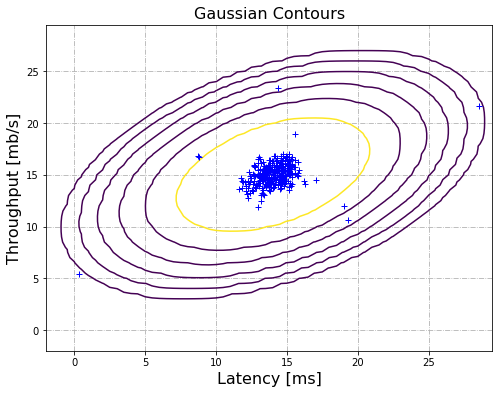

In [8]:
#plotData(X_train_two_dimension, newFig=True)
#plotContours(*getGaussianParams(X_train_two_dimension), newFig=False)

plotData(X_train_two_dimension, newFig=True)
plotContours(*getGaussianParams(X_train_two_dimension), newFig=False)

### 5. Selecting the threshold

In [9]:
def computeF1(predVec, trueVec):
    """
    F1 = 2 * (P*R)/(P+R)
    where P is precision, R is recall
    Precision = "of all predicted y=1, what fraction had true y=1"
    Recall = "of all true y=1, what fraction predicted y=1?
    Note predictionVec and trueLabelVec should be boolean vectors.
    """
    
    P, R = 0., 0.
    if float(np.sum(predVec)):
        P = np.sum([int(trueVec[x]) for x in range(predVec.shape[0]) \
                    if predVec[x]]) / float(np.sum(predVec))
    if float(np.sum(trueVec)):
        R = np.sum([int(predVec[x]) for x in range(trueVec.shape[0]) \
                    if trueVec[x]]) / float(np.sum(trueVec))
        
    return 2*P*R/(P+R) if (P+R) else 0

In [10]:
def selectThreshold(myY, gaussian):
    """
    Function to select the best epsilon value from the CV set
    by looping over possible epsilon values and computing the F1
    score for each.
    """
    # Make a list of possible epsilon values
    nsteps = 1000
    epses = np.linspace(np.min(gaussian),np.max(gaussian),nsteps)
    
    # Compute the F1 score for each epsilon value, and store the best 
    # F1 score (and corresponding best epsilon)
    bestF1, bestEps = 0, 0
    trueVec = (myY == 1).flatten()
    for eps in epses:
        predVec = gaussian < eps
        thisF1 = computeF1(predVec, trueVec)
        if thisF1 > bestF1:
            bestF1 = thisF1
            bestEps = eps
            
    print ("Best F1 is %f, best eps is %0.4g."%(bestF1,bestEps))
    return bestF1, bestEps

The function above is built to optimize the threshold for anamoly. No output is expected.

In [11]:
# Using the gaussian parameters from the full training set,
# figure out the p-value for each point in the CV set
gaus_value = gaus(X_train_two_dimension, mu, sig2)

#You should see a value for epsilon of about 8.99e-05.
bestF1, bestEps = selectThreshold(y_train_two_dimension, gaus_value)

Best F1 is 0.888889, best eps is 0.0007865.


In [12]:
def plotAnomalies(myX, myXY, mybestEps, newFig = False):
    ps = gaus(myX, *getGaussianParams(myX))
    anoms_pred = np.array([myX[x] for x in range(myX.shape[0]) if ps[x] <= mybestEps])
    anoms_true = np.array([myXY[x] for x in range(myXY.shape[0]) if myXY[x,2]==1])
    
#     y_pred = np.array([1 if ps[x] <= mybestEps else 0 for x in range(myX.shape[0]) ])
#     y_true = np.array([1 if myXY[x,2]==1 else 0 for x in range(myXY.shape[0]) ])
    
    if newFig: plt.figure(figsize=(6,4))
    plt.scatter(anoms_true[:,0],anoms_true[:,1], s=80, facecolors='r', edgecolors='None')
    plt.scatter(anoms_pred[:,0],anoms_pred[:,1], s=120, facecolors='b', edgecolors='y')

The function above is built to plot anomaly. No output is expected.

#### Train Set 

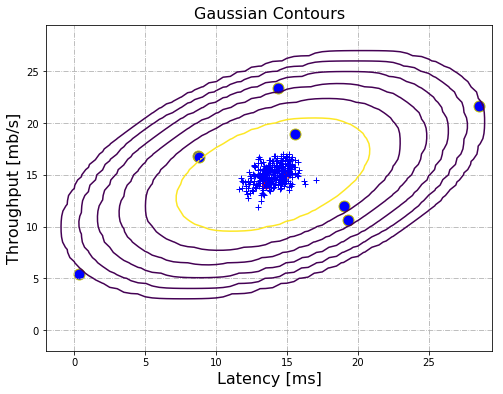

In [13]:
plotData(X_train_two_dimension, newFig=True)
plotContours(mu, sig2, newFig=False)
plotAnomalies(X_train_two_dimension, train_two_dimension, bestEps, newFig=False)

### Test Set

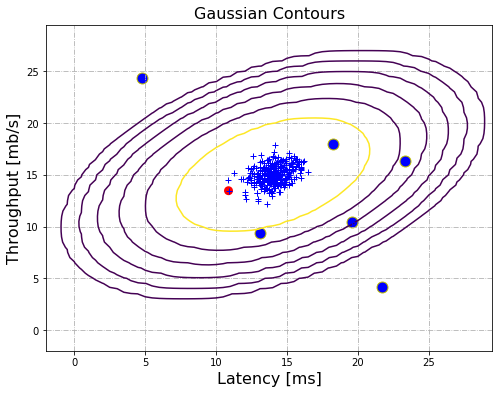

In [14]:
plotData(X_test_two_dimension, newFig=True)
plotContours(mu, sig2, newFig=False)
plotAnomalies(X_test_two_dimension, test_two_dimension, bestEps, newFig=False)

### 6. High dimensional dataset

In [15]:
### import cross validation high dimension data and convert from pandas dataframe to numpy array
train_high_dimension = pd.read_csv('./data/train_high_dimension.csv')
train_high_dimension = np.array(train_high_dimension)

X_train_high_dimension = train_high_dimension[:,:-1]
y_train_high_dimension = train_high_dimension[:,-1]

### import x train high dimension data and convert from pandas dataframe to numpy array
X_test_high_dimension = pd.read_csv('./data/X_test_high_dimension.csv')
X_test_high_dimension = np.array(X_test_high_dimension)

print ('X train high dimension shape is ', X_train_high_dimension.shape)

X train high dimension shape is  (100, 11)


 ### 7. Apply the model in the two dimentional inputs to high dimentional dataset

#### Using high dimensiond train set to estimate the paramters

In [16]:
mu, sig2 = getGaussianParams(X_train_high_dimension)
print('Mean of each input:', mu)

Mean of each input: [ 4.52102216 -9.39653433 14.00869728 -9.84111614 -7.8263786  13.18626529
 -5.64498345  7.33270816 -5.91685457  2.03708579  7.46572725]


#### Using high dimensiond train set to optimize the threshold

In [17]:
gaus_value_high = gaus(X_train_high_dimension, mu, sig2)
bestF1, bestEps = selectThreshold(y_train_high_dimension, gaus_value_high)

Best F1 is 0.666667, best eps is 8.043e-19.


### 8. Challenge for you 
### *Based on the training output of mean (mu) and variance (sig2), can you calculate the Gaussian distribution of test set?*

In [18]:
##### Misssion
# ====================== YOUR CODE HERE ======================
### One Line Code
gaus_test = 

SyntaxError: invalid syntax (<ipython-input-18-a4dfad58e3da>, line 4)

#### Based on the optimized threshold and Gaussian distribution, find out the anomaly in the test set

In [ ]:
anoms = [X_test_high_dimension[x] for x in range(X_test_high_dimension.shape[0]) if gaus_test[x] < bestEps]
print ('# of anomalies found: ',len(anoms))